# Lab2: Skip-Gram & CBOW


Clara Paola Aguilar Casillas

Daniela De La Torre Gallo

Samantha Sánchez Tinoco

------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
import re
import random
from collections import Counter
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
try:
    from umap import UMAP
    UMAP_AVAILABLE = True
    print("✓ UMAP disponible")
except ImportError:
    UMAP_AVAILABLE = False
    print("✗ UMAP no disponible. Instala con: pip install umap-learn")

✗ UMAP no disponible. Instala con: pip install umap-learn


In [ ]:
with open("../data/text8", "r") as f:
    text = f.read().lower() # Todo en minúsculas

print("Ejemplo de texto original:")
print(text[:200])

Ejemplo de texto original:
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term 


## 1. Pre-processing

### Load dataset

### Basic data wrangling

In [4]:
# Eliminamos todo lo que no sean letras y tokenizamos por palabras
words = re.findall(r'\b[a-z]+\b', text)
print(f"\nTotal de palabras en el corpus: {len(words):,}")


Total de palabras en el corpus: 17,005,207


In [ ]:
# Filter rare words and limit vocabulary
freq = Counter(words)

In [ ]:
# Filter words with frequency less than 5
filtered = [w for w in words if freq[w] >= 5]

In [ ]:
# Limit vocabulary to the 50,000 most common words
most_common = freq.most_common(50000)
vocab = [w for w, c in most_common]
print(f"\nSize of the final vocabulary: {len(vocab):,}")


Tamaño del vocabulario final: 50,000


In [ ]:
# Create word to index and index to word mappings
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

In [ ]:
# Function to generate Skip-gram pairs
def generate_skipgram_pairs(words, window_size_range=(2, 5)):
    """Genera pares (target, context) para Skip-gram"""
    pairs = []
    for i, word in enumerate(words):
        if word not in word2idx:
            continue
        window_size = random.randint(*window_size_range)
        start = max(0, i - window_size)
        end = min(len(words), i + window_size + 1)
        context = [w for j, w in enumerate(words[start:end]) if j != i and w in word2idx]
        for ctx_word in context:
            pairs.append((word, ctx_word))  # (target, context)
    return pairs

In [ ]:
# Function to generate CBOW pairs
def generate_cbow_pairs(words, window_size_range=(2, 5)):
    """Genera pares (context, target) para CBOW"""
    pairs = []
    for i, word in enumerate(words):
        if word not in word2idx:
            continue
        window_size = random.randint(*window_size_range)
        start = max(0, i - window_size)
        end = min(len(words), i + window_size + 1)
        context = [w for j, w in enumerate(words[start:end]) if j != i and w in word2idx]
        if len(context) > 0:
            pairs.append((context, word))  # (context, target)
    return pairs

In [ ]:
# Generate Skip-gram and CBOW pairs
print("\nGenerating Skip-gram pairs...")
skipgram_pairs = generate_skipgram_pairs(filtered[:200000])  # Limit to first 200,000 words for speed
print(f"Generated Skip-gram pairs: {len(skipgram_pairs):,}")

print("\nGenerating CBOW pairs...")
cbow_pairs = generate_cbow_pairs(filtered[:200000])
print(f"Generated CBOW pairs: {len(cbow_pairs):,}")


Generando pares Skip-gram (esto puede tardar unos minutos)...
Pares Skip-gram generados: 1,579,927

Generando pares CBOW (esto puede tardar unos minutos)...
Pares CBOW generados: 198,618


In [ ]:
# Convert to tensors (example with Skip-gram)

targets_sg = torch.tensor([word2idx[t] for t, _ in skipgram_pairs], dtype=torch.long)
contexts_sg = torch.tensor([word2idx[c] for _, c in skipgram_pairs], dtype=torch.long)

print("\nEjemplo de pares Skip-gram (target → context):")
for i in range(5):
    print(f"{idx2word[targets_sg[i].item()]} → {idx2word[contexts_sg[i].item()]}")# 7. Convertir a tensores (ejemplo con Skip-gram)
# ----------------------------------
targets_sg = torch.tensor([word2idx[t] for t, _ in skipgram_pairs], dtype=torch.long)
contexts_sg = torch.tensor([word2idx[c] for _, c in skipgram_pairs], dtype=torch.long)

print("\nEjemplo de pares Skip-gram (target → context):")
for i in range(5):
    print(f"{idx2word[targets_sg[i].item()]} → {idx2word[contexts_sg[i].item()]}")


Ejemplo de pares Skip-gram (target → context):
anarchism → originated
anarchism → as
anarchism → a
originated → anarchism
originated → as

Ejemplo de pares Skip-gram (target → context):
anarchism → originated
anarchism → as
anarchism → a
originated → anarchism
originated → as


In [ ]:
# Convert to tensors (example with CBOW)

print("\nEjemplo de pares CBOW (context → target):")
for i in range(3):
    context_words, target = cbow_pairs[i]
    print(f"{context_words} → {target}")


Ejemplo de pares CBOW (context → target):
['originated', 'as', 'a', 'term', 'of'] → anarchism
['anarchism', 'as', 'a', 'term'] → originated
['anarchism', 'originated', 'a', 'term', 'of', 'abuse'] → as


## 2. PyTorch Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

Usando dispositivo: cpu


### Dataset especial para Skip Gram

In [ ]:
class SkipGramDataset(Dataset):
    def __init__(self, targets, contexts):
        self.targets = targets
        self.contexts = contexts

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.targets[idx], self.contexts[idx]

# Create DataLoader for Skip-gram
sg_dataset = SkipGramDataset(targets_sg, contexts_sg)
sg_loader = DataLoader(sg_dataset, batch_size=512, shuffle=True)

In [ ]:
# Define the Skip-gram model
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGramModel, self).__init__()
        self.in_embed = nn.Embedding(vocab_size, embed_dim)
        self.out_embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, target, context):
        # target: (batch_size)
        # context: (batch_size)
        v = self.in_embed(target)             # (batch_size, embed_dim)
        u = self.out_embed(context)           # (batch_size, embed_dim)
        score = torch.sum(v * u, dim=1)       # Pointwise dot product
        return score


### Entrenamiento del modelo

In [ ]:
def train_skipgram(model, dataloader, epochs=3, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for target, context in dataloader:
            target, context = target.to(device), context.to(device)

            # Prediction of all possible contexts
            pred = torch.matmul(model.in_embed(target), model.out_embed.weight.T)

            # Cálculo de la pérdida
            loss = criterion(pred, context)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    return losses

In [ ]:
# Train Skip-gram model
vocab_size = len(vocab)
embed_dim = 100  # Embedding dimension

model_sg = SkipGramModel(vocab_size, embed_dim).to(device)

losses_sg = train_skipgram(model_sg, sg_loader, epochs=5, lr=0.003)


Epoch 1/5 - Loss: 14.7434
Epoch 2/5 - Loss: 7.5572
Epoch 3/5 - Loss: 6.4982
Epoch 4/5 - Loss: 6.1255
Epoch 5/5 - Loss: 5.9410


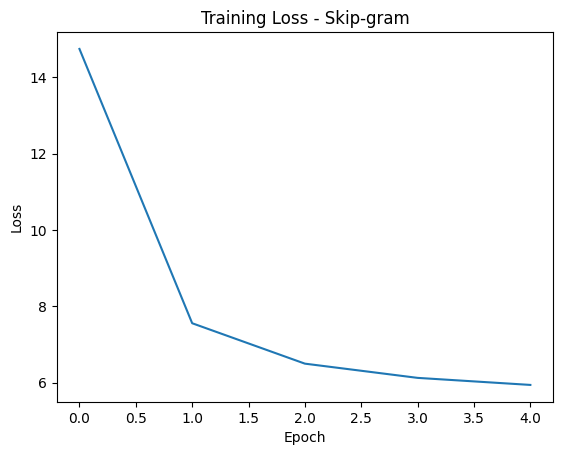

In [ ]:
# Loss plot for Skip-gram
plt.plot(losses_sg)
plt.title("Training Loss - Skip-gram")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


### CBOW Model

In [ ]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWModel, self).__init__()
        self.in_embed = nn.Embedding(vocab_size, embed_dim)
        self.out_embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, context):
        # context: (batch_size, window_size)
        v = self.in_embed(context)          # (batch_size, window_size, embed_dim)
        v = torch.mean(v, dim=1)            # (batch_size, embed_dim)
        scores = torch.matmul(v, self.out_embed.weight.T)  # (batch_size, vocab_size)
        return scores  


In [ ]:
# Convert CBOW to tensors
contexts_cbow = [torch.tensor([word2idx[w] for w in ctx]) for ctx, _ in cbow_pairs]
targets_cbow = torch.tensor([word2idx[t] for _, t in cbow_pairs], dtype=torch.long)

# Adjust for variable context sizes by padding
from torch.nn.utils.rnn import pad_sequence

contexts_padded = pad_sequence(contexts_cbow, batch_first=True, padding_value=0)

class CBOWDataset(Dataset):
    def __init__(self, contexts, targets):
        self.contexts = contexts
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.contexts[idx], self.targets[idx]

cbow_dataset = CBOWDataset(contexts_padded, targets_cbow)
cbow_loader = DataLoader(cbow_dataset, batch_size=512, shuffle=True)


In [22]:
def train_cbow(model, dataloader, epochs=3, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for context, target in dataloader:
            context, target = context.to(device), target.to(device)
            pred = model(context)
            loss = criterion(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    return losses


In [ ]:
# Train CBOW model
model_cbow = CBOWModel(vocab_size, embed_dim).to(device)
losses_cbow = train_cbow(model_cbow, cbow_loader, epochs=5, lr=0.003)

Epoch 1/5 - Loss: 10.8064
Epoch 2/5 - Loss: 6.5658
Epoch 3/5 - Loss: 5.4418
Epoch 4/5 - Loss: 4.7412
Epoch 5/5 - Loss: 4.2246


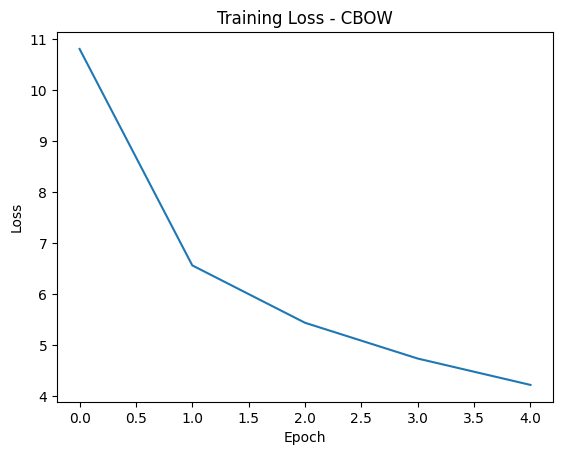

In [24]:
plt.plot(losses_cbow)
plt.title("Training Loss - CBOW")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Evaluation and visualization

In [ ]:
# Obtain embeddings
embeddings_sg = model_sg.in_embed.weight.detach().cpu().numpy()
embeddings_cbow = model_cbow.in_embed.weight.detach().cpu().numpy()

### Cualitative evaluation

In [ ]:
# Search for similar words
def find_similar_words(word, embeddings, top_n=10):
    if word not in word2idx:
        print(f"'{word}' no está en el vocabulario.")
        return
    
    idx = word2idx[word]
    word_vec = embeddings[idx].reshape(1, -1)
    similarities = cosine_similarity(word_vec, embeddings)[0]
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    
    print(f"\n🔹 Palabras más similares a '{word}':")
    for i in similar_indices:
        print(f"{idx2word[i]:<15} (similitud = {similarities[i]:.4f})")

In [35]:
for anchor in ["king", "apple", "run", "doctor"]:
    find_similar_words(anchor, embeddings_sg)


🔹 Palabras más similares a 'king':
plekhanov       (similitud = 0.4848)
stephen         (similitud = 0.4617)
daughter        (similitud = 0.4454)
meant           (similitud = 0.4425)
johnson         (similitud = 0.4346)
f               (similitud = 0.4316)
swain           (similitud = 0.4306)
bittersweet     (similitud = 0.4291)
priam           (similitud = 0.4266)
formulate       (similitud = 0.4245)

🔹 Palabras más similares a 'apple':
backing         (similitud = 0.4234)
weathered       (similitud = 0.4229)
pogo            (similitud = 0.3953)
perform         (similitud = 0.3945)
hub             (similitud = 0.3936)
audiobook       (similitud = 0.3933)
major           (similitud = 0.3912)
remedy          (similitud = 0.3890)
worked          (similitud = 0.3869)
thinkers        (similitud = 0.3790)

🔹 Palabras más similares a 'run':
make            (similitud = 0.5524)
winner          (similitud = 0.4775)
possessed       (similitud = 0.4766)
november        (similitud = 0.4741)
ball

### Dimension reduction

In [ ]:
# Select a subset of words for visualization

n_words = 300
selected_indices = [word2idx[w] for w, _ in freq.most_common(n_words)]
selected_embeddings = embeddings_sg[selected_indices]
selected_words = [w for w, _ in freq.most_common(n_words)]


In [ ]:
# TSNE dimension reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d_tsne = tsne.fit_transform(selected_embeddings)


In [ ]:
# UMAP dimension reduction
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d_umap = reducer.fit_transform(selected_embeddings)

### Visualizations

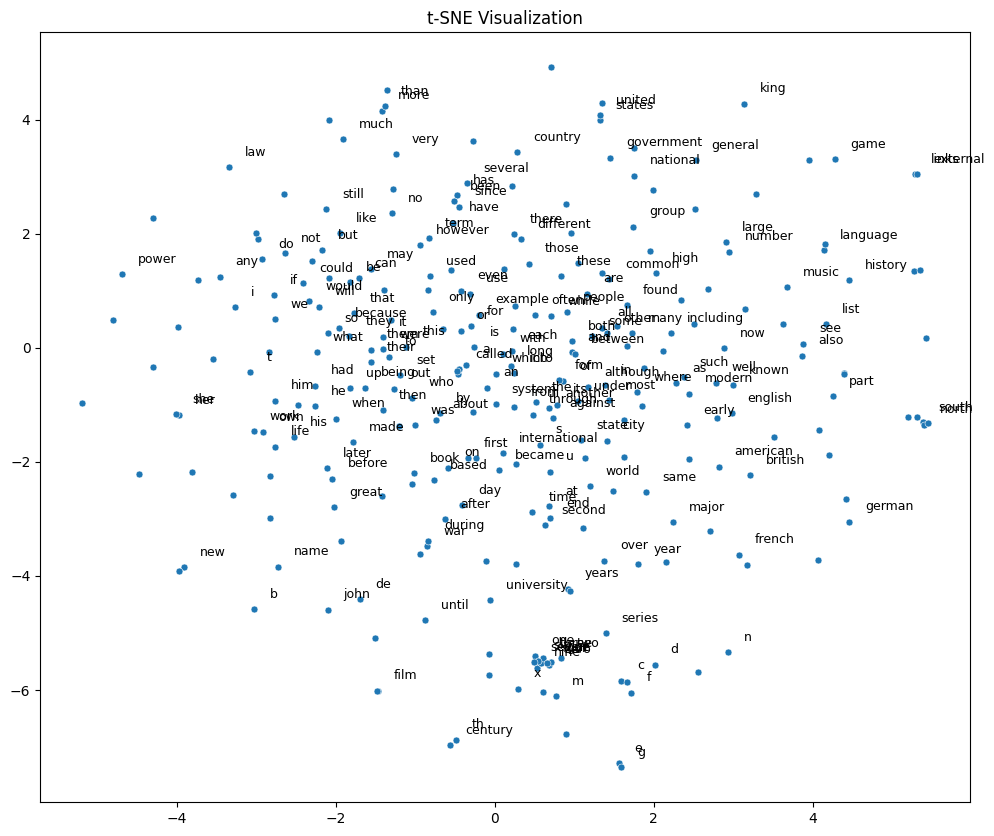

In [41]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=embeddings_2d_tsne[:, 0], y=embeddings_2d_tsne[:, 1], s=25)
for i, word in enumerate(selected_words[:200]):  # solo etiquetar 200 para claridad
    plt.text(embeddings_2d_tsne[i, 0]+0.2, embeddings_2d_tsne[i, 1]+0.2, word, fontsize=9)
plt.title("t-SNE Visualization")
plt.show()


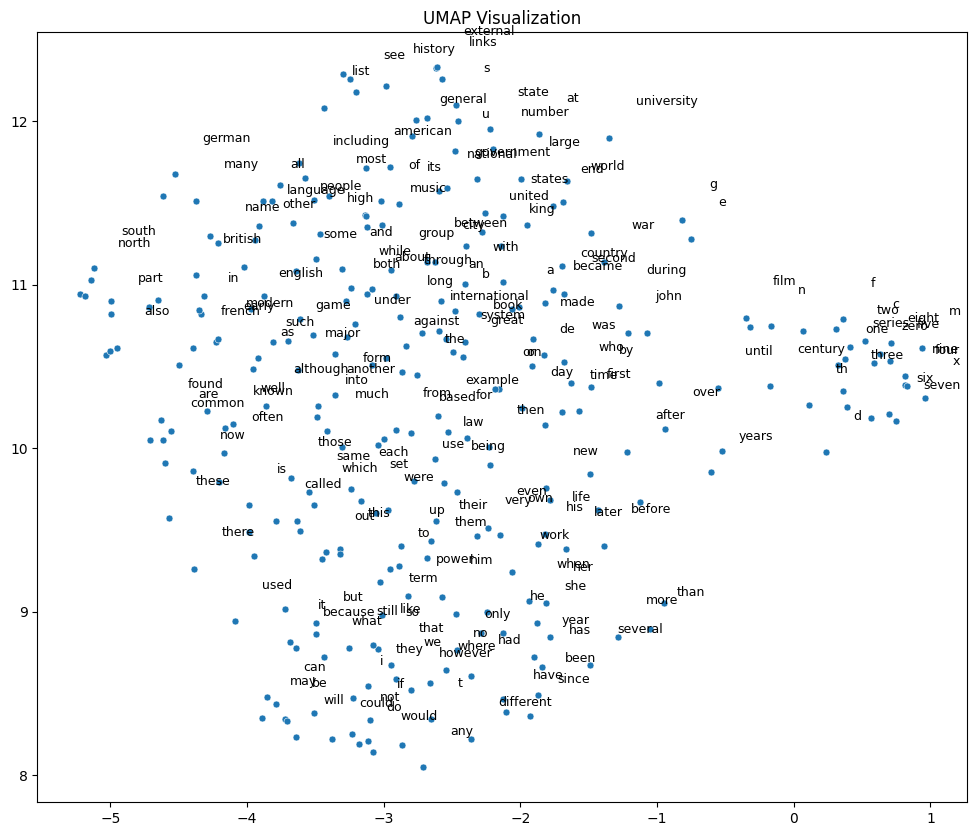

In [42]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=embeddings_2d_umap[:, 0], y=embeddings_2d_umap[:, 1], s=25)
for i, word in enumerate(selected_words[:200]):
    plt.text(embeddings_2d_umap[i, 0]+0.2, embeddings_2d_umap[i, 1]+0.2, word, fontsize=9)
plt.title("UMAP Visualization")
plt.show()
